In [3]:
import datasets
import pandas as pd
df = pd.read_csv("./women-clothing-accessories.3-class.balanced.csv", sep="\t")
ds = datasets.Dataset.from_pandas(df)

In [10]:
ds = ds.class_encode_column("sentiment")

Casting to class labels: 100%|██████████| 90000/90000 [00:00<00:00, 817652.71 examples/s]


In [14]:
ds = ds.train_test_split(test_size=0.2, shuffle=True, stratify_by_column="sentiment", seed=42)

In [16]:
ds.save_to_disk("./data/rureviews")

Saving the dataset (1/1 shards): 100%|██████████| 18000/18000 [00:00<00:00, 593235.10 examples/s]


# Sentiment Analysis in Russian

In [1]:
import json
train = eval(open("train.json", "r").read())
test = eval(open("test.json", "r").read())

In [7]:
import datasets
dataset = datasets.Dataset.from_list(train)
dataset = dataset.class_encode_column("sentiment")
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, stratify_by_column="sentiment")

Casting to class labels: 100%|██████████| 8263/8263 [00:00<00:00, 211887.15 examples/s]


In [8]:
dataset.save_to_disk("./data/runews")

Saving the dataset (1/1 shards): 100%|██████████| 1653/1653 [00:00<00:00, 136622.55 examples/s]


# tweets

In [13]:
import pandas as pd
train = pd.read_csv("./rusentitweet/rusentitweet_train.csv", index_col=0)
test = pd.read_csv("./rusentitweet/rusentitweet_test.csv", index_col=0)

In [25]:
test = test[test['label'].isin(set(["neutral", "negative", "positive"]))]
train = train[train['label'].isin(set(["neutral", "negative", "positive"]))]

In [28]:
import datasets
dataset = datasets.DatasetDict({
    "train": datasets.Dataset.from_pandas(train),
    "test": datasets.Dataset.from_pandas(test)
})

In [34]:
dataset['train'] = dataset['train'].class_encode_column("label")

Casting to class labels: 100%|██████████| 8842/8842 [00:00<00:00, 917108.56 examples/s]


In [35]:
dataset['test'] = dataset['test'].class_encode_column("label")

Casting to class labels: 100%|██████████| 2211/2211 [00:00<00:00, 456153.77 examples/s]


In [36]:
dataset.save_to_disk("./data/rutweets")

Saving the dataset (1/1 shards): 100%|██████████| 2211/2211 [00:00<00:00, 1086283.96 examples/s]


# EDA

In [37]:
import datasets

In [59]:
import seaborn as sns

runews = datasets.load_from_disk("./data/runews")
rureviews = datasets.load_from_disk("./data/rureviews")
rutweets = datasets.load_from_disk("./data/rutweets")

runews = runews.rename_columns({"sentiment": "label"})
rureviews = rureviews.rename_columns({"review": "text", "sentiment": "label"})

runews_df = runews['train'].to_pandas()
runews_df['label'] = runews_df['label'].map(lambda label: runews['train'].features['label'].names[label])
runews_df["dataset"] = "runews"
rureviews_df = rureviews['train'].to_pandas()
rureviews_df['dataset'] = "rureviews"
rureviews_df['label'] = rureviews_df['label'].map(lambda label: rureviews['train'].features['label'].names[label])
rutweets_df = rutweets['train'].to_pandas()
rutweets_df["dataset"] = "rutweets"
rutweets_df['label'] = rutweets_df['label'].map(lambda label: rutweets['train'].features['label'].names[label])

df = pd.concat([runews_df, rureviews_df, rutweets_df], axis=0)

In [62]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
df['n_tokens'] = df['text'].map(lambda text: len(tokenizer(text)['input_ids']))

/home/leo/hw/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [63]:
df['n_tokens']

0        222
1        824
2       1812
3        263
4       1800
        ... 
8837      26
8838      26
8839      50
8840      15
8841      38
Name: n_tokens, Length: 87452, dtype: int64

In [68]:
import matplotlib.pyplot as plt

def plot_ds(dataset):
    f, axs = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(data=df[df['dataset'] == dataset], x="n_tokens", ax=axs[0])
    sns.histplot(data=df[df['dataset'] == dataset], x="label", ax=axs[1])
    axs[1].set_title("Распределение сентимента")
    axs[0].set_title("Распределение количества токенов в тексте (токенайзер ruRoberta)")
    f.suptitle(f"Набор данных {dataset}")
    return f, axs


(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'Распределение количества токенов в тексте (токенайзер ruRoberta)'}, xlabel='n_tokens', ylabel='Count'>,
        <Axes: title={'center': 'Распределение сентимента'}, xlabel='label', ylabel='Count'>],
       dtype=object))

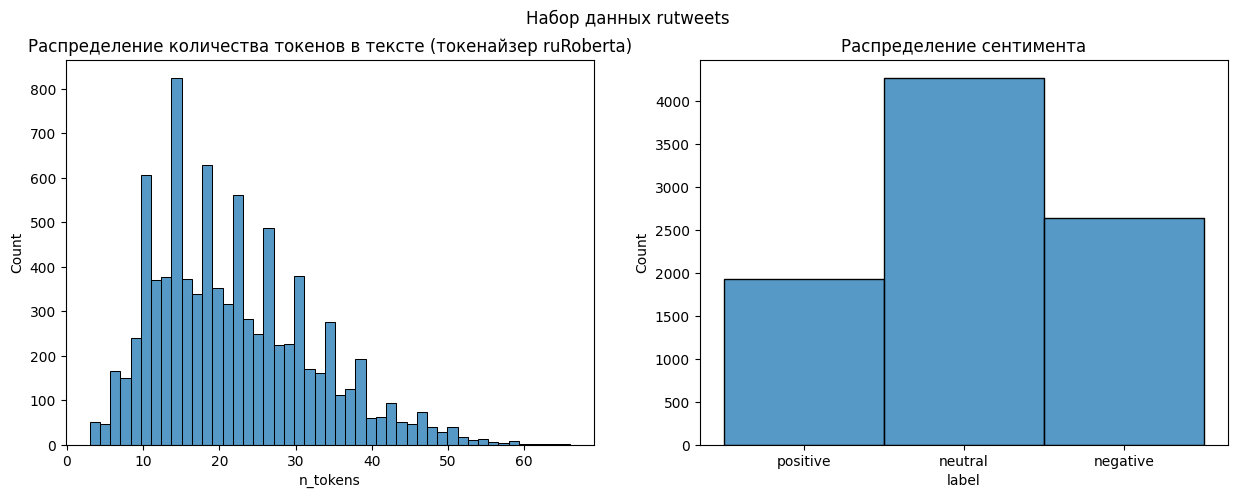

In [69]:
plot_ds("rutweets")

(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'Распределение количества токенов в тексте (токенайзер ruRoberta)'}, xlabel='n_tokens', ylabel='Count'>,
        <Axes: title={'center': 'Распределение сентимента'}, xlabel='label', ylabel='Count'>],
       dtype=object))

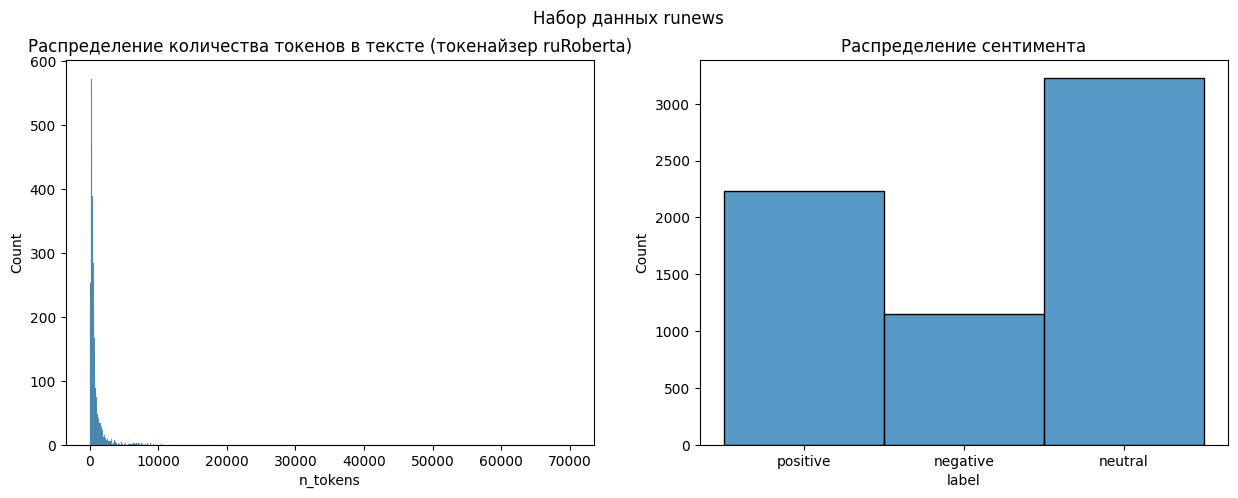

In [70]:
plot_ds("runews")

(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'Распределение количества токенов в тексте (токенайзер ruRoberta)'}, xlabel='n_tokens', ylabel='Count'>,
        <Axes: title={'center': 'Распределение сентимента'}, xlabel='label', ylabel='Count'>],
       dtype=object))

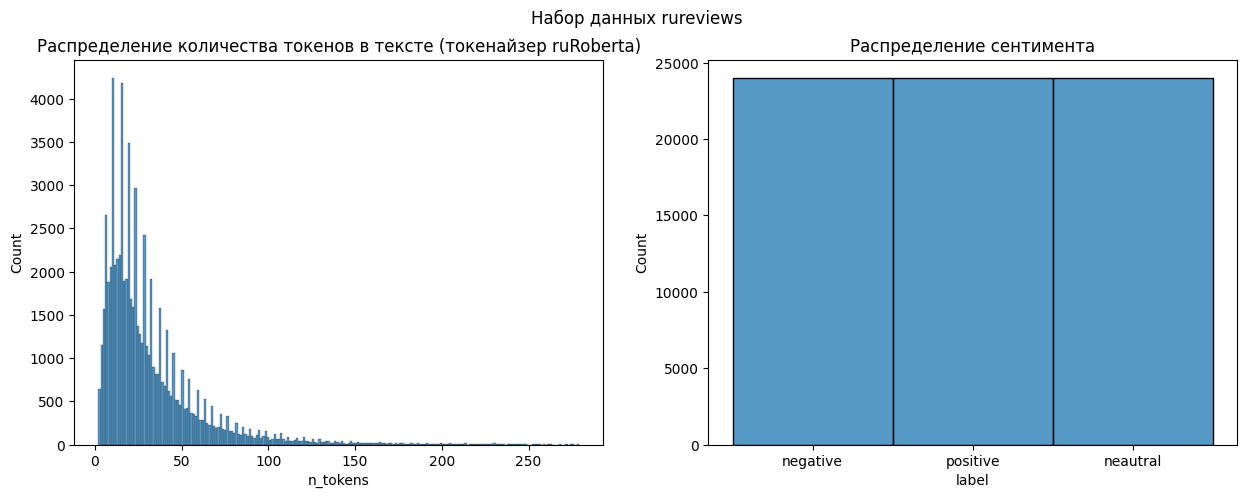

In [71]:
plot_ds("rureviews")